In [1]:
import numpy as np
import skimage.transform
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
import PIL.ImageDraw
import PIL.Image
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


## Dictionary to map file keys from STScI to Krist

In [2]:
prim_key_map = {'hex1':'hex1', 'hex2':'hex2', 'hex3':'hex3', 'hex4':'hex4',
                 'key24':'keystone24', 'pie08':'piewedge8', 'pie12':'piewedge12'}
telap_dir = os.path.normpath('/astro/opticslab1/SCDA/Apertures/JPL/offset_masks')

## Set basic parameters

In [3]:
overwrite = False
N = 250 # pupil array quadrant width after binning
iD = 30
oD = 90 # _LS_OD_map = {'hex1':76, 'hex2':82, 'hex3':81, 'hex4':82, 'pie08':90,
aligntol = 2 # units of thousandths of pupil diameter
L = 1024 # starting array width
D = 1000 # starting pupil diameter
symm = 'quart' # set to either 'quart' or 'half'
shape = 'ann' # set to 'ann' or 'hex' or a primary mirror key
#shape = 'hex2' # set to 'ann' or 'hex' or telap key
edge = 'round' # set to 'gray' or 'round'

In [4]:
LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks/LS")
#LS_dir = os.path.expanduser("~/Box Sync/scda/InputMasks_wfirst/LS")

if not os.path.exists(LS_dir):
    os.mkdir(LS_dir)
    print("created {:s} for LS arrays".format(LS_dir))
else:
    print("Destination {:s} already exists".format(LS_dir))

Destination /astro/opticslab1/SCDA/Apertures/InputMasks/LS already exists


## Define annular stop

In [5]:
inD = float(iD)/100
outD = float(oD)/100
xs = np.linspace(-L/2 + 0.5, L/2 - 0.5, L)
[Xs, Ys] = np.meshgrid(xs, xs)

if shape is 'hex':
    xycent = (L/2-0.5,L/2-0.5)
    hexagon_obj = matplotlib.patches.RegularPolygon(xycent,6,radius=outD*D/2/np.cos(np.pi/6))
    hexagon_verts = hexagon_obj.get_verts()
    hexagon_img = PIL.Image.new('L', (L,L), 0)
    PIL.ImageDraw.Draw(hexagon_img).polygon(list(hexagon_verts.ravel()), outline=1, fill=1)
    hexagon_mask = np.array(hexagon_img)
    Lyot_stop = hexagon_mask
    inside_ann = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
    Lyot_stop[inside_ann] = 0.
elif shape in prim_key_map: # Lyot stop with outer edge tracing the aperture perimeter 
    # Numerically erase the segment gaps
    prim_fname = os.path.join(telap_dir, "{0:s}_{1:04d}pix_offset_no_central_obsc.fits".format(
                                          prim_key_map[shape], D))
    prim = fits.getdata(prim_fname)
    max_shift = 1e-6
    shift_range = np.linspace(-max_shift,max_shift,3)
    [Xshifts, Yshifts] = np.meshgrid(shift_range, shift_range)
    allowed_shifts = np.less_equal(Xshifts**2 + Yshifts**2, max_shift**2)
    XYshifts_allowed = zip(Xshifts[allowed_shifts], Yshifts[allowed_shifts])
    nogap_prim = np.zeros(prim.shape)
    for (xshift,yshift) in XYshifts_allowed:
        shift = skimage.transform.SimilarityTransform(translation=(xshift,yshift))
        prim_shifted = skimage.transform.warp(prim, shift, order=1)
        nogap_prim = np.logical_or(nogap_prim, prim_shifted)
    perim = np.ndarray.astype(nogap_prim, np.float)
    # Define the undersized stop outer edge based on a shift-and-multiply padding loop
    w = D*(1. - outD)/2
    XYshifts_allowed = [(-w,0), (+w,0),
                        (+w*np.sin(np.pi/6),+w*np.cos(np.pi/6)), (-w*np.sin(np.pi/6),+w*np.cos(np.pi/6)),
                        (+w*np.sin(np.pi/6),-w*np.cos(np.pi/6)), (-w*np.sin(np.pi/6),-w*np.cos(np.pi/6))]
    padded_perim = np.ones(perim.shape)
    for (xshift,yshift) in XYshifts_allowed:
        shift = skimage.transform.SimilarityTransform(translation=(xshift,yshift))
        perim_shifted = skimage.transform.warp(perim, shift, order=1)
        padded_perim *= perim_shifted
    Lyot_stop = padded_perim.copy()
    # define inner, circular edge
    inside_ann = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
    Lyot_stop[inside_ann] = 0.
    plt.figure(figsize=(16,16))
    plt.imshow(Lyot_stop - perim)
else:
    inside_ann = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
    outside_ann = np.greater_equal(Xs**2 + Ys**2, (outD*D/2)**2)
    Lyot_stop = np.ones((L,L))
    Lyot_stop[inside_ann] = 0.
    Lyot_stop[outside_ann] = 0.

In [6]:
np.sum(Lyot_stop)/L**2

0.539276123046875

## Bin to final array resolution, crop

In [7]:
#scalefac = float(N)/(D/2)
#Lyot_stop_binned = skimage.transform.rescale(Lyot_stop, scalefac, order=1)

In [9]:
N_orig = D/2
Lyot_stop_crop = Lyot_stop[L/2-N_orig:L/2+N_orig,L/2-N_orig:L/2+N_orig]
scalefac = int(N_orig/N)
print("Binning the original LS array {0:d}x".format(scalefac))
Lyot_stop_binned = np.reshape(Lyot_stop_crop, (Lyot_stop_crop.shape[0]/scalefac, scalefac, 
                                               Lyot_stop_crop.shape[1]/scalefac, scalefac)).mean(1).mean(2)

Binning the original LS array 2x


In [10]:
Lyot_stop_crop.shape

(1000, 1000)

In [11]:
Lyot_stop_binned.shape

(500, 500)

In [12]:
L_bin = Lyot_stop_binned.shape[0]
if symm is 'half':
    Lyot_stop_binned_crop = Lyot_stop_binned[L_bin/2-N:L_bin/2+N,L_bin/2:L_bin/2+N]
    Lyot_stop_binned_crop_binary = np.round(Lyot_stop_binned_crop).astype(int)
    print Lyot_stop_binned_crop.shape
else:
    Lyot_stop_binned_crop = Lyot_stop_binned[L_bin/2:L_bin/2+N,L_bin/2:L_bin/2+N]
    Lyot_stop_binned_crop_binary = np.round(Lyot_stop_binned_crop).astype(int)
    print Lyot_stop_binned_crop.shape

(250, 250)


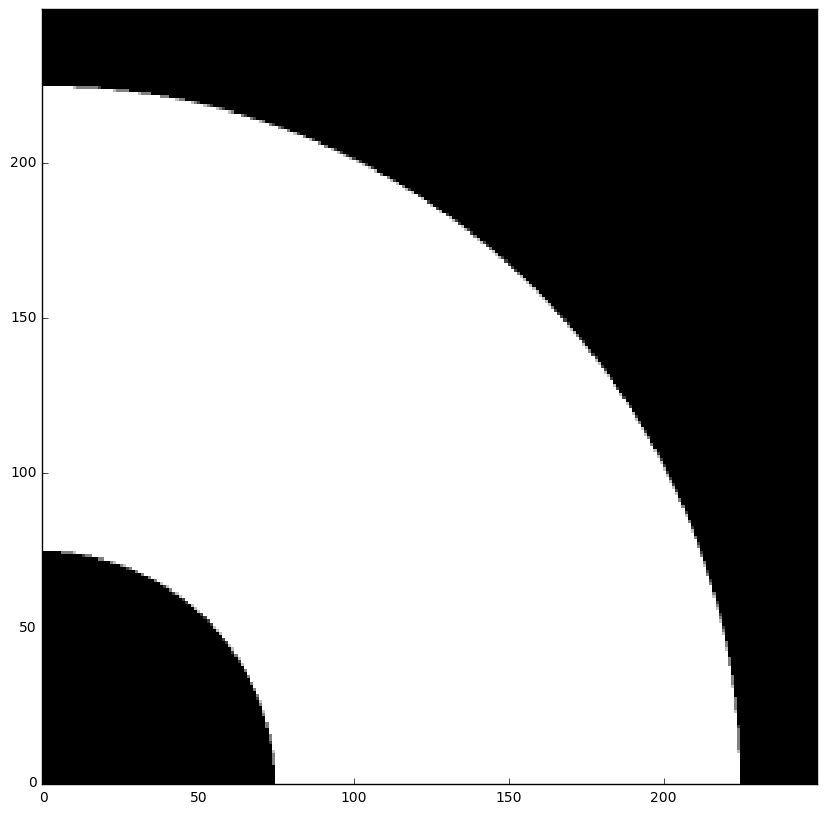

In [13]:
if symm is 'half':
    plt.figure(figsize=(20,10))
    #plt.imshow(Lyot_stop_binned_crop_binary)
    plt.imshow(Lyot_stop_binned_crop)
else:
    plt.figure(figsize=(10,10))
    plt.imshow(Lyot_stop_binned_crop)
    #plt.imshow(Lyot_stop_binned_crop_binary)

## Write the binned, cropped Lyot stop to a dat (ASCII) file 

In [14]:
if symm is 'half':
    if shape in ['ann', 'hex']:
        LS_dat_fname_tail = "LS_half_{0:s}{1:02d}D{2:02d}_clear_N{3:04d}.dat".format(
                             shape, int(round(100*inD)), int(round(100*outD)), N)
    else:
        LS_dat_fname_tail = "LS_half_{0:s}P{1:02d}D{2:02d}_clear_N{3:04d}.dat".format(
                             shape, int(round(100*inD)), int(round(100*outD)), N)
else:
    if shape in ['ann', 'hex']:
        LS_dat_fname_tail = "LS_quart_{0:s}{1:02d}D{2:02d}_clear_N{3:04d}.dat".format(
                             shape, int(round(100*inD)), int(round(100*outD)), N)
    else:
        LS_dat_fname_tail = "LS_quart_{0:s}P{1:02d}D{2:02d}_clear_N{3:04d}.dat".format(
                             shape, int(round(100*inD)), int(round(100*outD)), N)
        
LS_dat_fname = os.path.join(LS_dir, LS_dat_fname_tail)

if not os.path.exists(LS_dat_fname) or overwrite==True:
    if edge is 'gray':
        np.savetxt(LS_dat_fname, Lyot_stop_binned_crop, fmt='%.6f', delimiter=" ")
    else: # store version rounded to binary integers
        np.savetxt(LS_dat_fname, Lyot_stop_binned_crop_binary, fmt='%d', delimiter=" ")
    print("Wrote binned, cropped LS array to {0:s}".format(LS_dat_fname))
else:
    print("LS array {0:s} already exists, will not overwrite".format(LS_dat_fname))

LS array /astro/opticslab1/SCDA/Apertures/InputMasks/LS/LS_quart_ann30D90_clear_N0250.dat already exists, will not overwrite


In [15]:
#if os.path.exists(LS_dat_fname): os.remove(LS_dat_fname)

# Define Lyot plane dark zone

In [16]:
orig_LS = np.round(Lyot_stop_binned[L_bin/2-N:L_bin/2+N,L_bin/2-N:L_bin/2+N]).astype(int)
dz_width_fac = float(aligntol)/1000              # dark zone is +/- this fraction of pupil diameter
dz_width = np.ceil(2*N*dz_width_fac).astype(int) # dark zone is +/- this number of pixels in binned pupil array
print("Lyot plane dark zone width in binned array: +/- {:d} pixels".format(dz_width))

Lyot plane dark zone width in binned array: +/- 1 pixels


In [17]:
max_shift = dz_width
shift_range = range(-max_shift,max_shift+1,1)
[Xshifts, Yshifts] = np.meshgrid(shift_range, shift_range)
allowed_shifts = np.less_equal(Xshifts**2 + Yshifts**2, max_shift**2)

In [18]:
allowed_shifts

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]], dtype=bool)

In [19]:
XYshifts_allowed = zip(Xshifts[allowed_shifts], Yshifts[allowed_shifts])
len(XYshifts_allowed)

5

In [20]:
fat_LS = np.ones(orig_LS.shape)
for (xshift,yshift) in XYshifts_allowed:
    LS_shifted = np.roll(np.roll(orig_LS, yshift, 0), xshift, 1)
    fat_LS *= LS_shifted

inv_thin_LS = np.ones(orig_LS.shape)
for (xshift,yshift) in XYshifts_allowed:
    inv_LS_shifted = 1-np.roll(np.roll(orig_LS, yshift, 0), xshift, 1)
    inv_thin_LS *= inv_LS_shifted
thin_LS = 1-inv_thin_LS

In [21]:
Lyot_dz = np.logical_xor(thin_LS, fat_LS)
L = Lyot_dz.shape[0]

if symm is 'half':
    Lyot_dz_crop = Lyot_dz[:,N:]
else:
    Lyot_dz_crop = Lyot_dz[N:,N:]

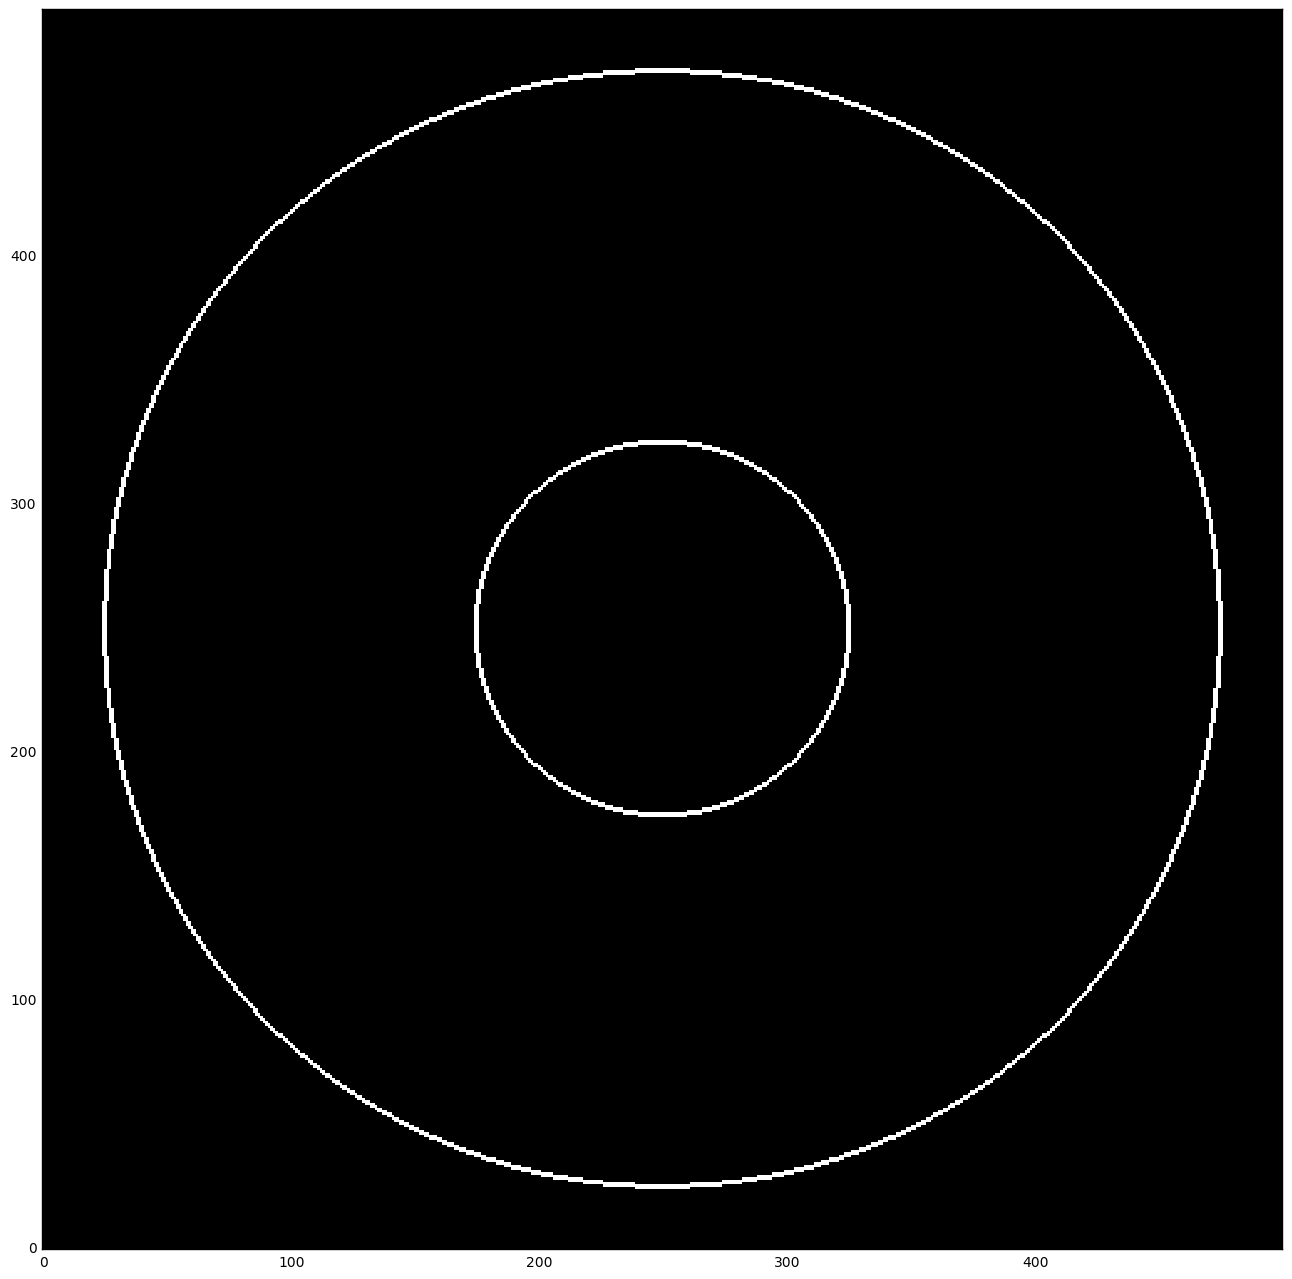

In [22]:
plt.figure(figsize=(16,16))
plt.imshow(Lyot_dz)

## Alignment tolerance check

In [23]:
max_shift_tol = 2*N*dz_width_fac
max_shift_tol_int = int(np.round(max_shift_tol))
test_shift = (max_shift_tol_int,0)
print("The LDZ accomomdates a translation +/-{0:.1f}% of D={1:d} pixels = +/-{2:.2f} pixels, up to +/-{3:d} whole pixels".format(
      float(aligntol)/10, 2*N, max_shift_tol, max_shift_tol_int))
print("Testing an (x,y) translation of {0:} pixels. Within the design tolerance? {1:}".format(
      test_shift, test_shift[0]**2 + test_shift[1]**2 <= max_shift_tol))
shift_LS = np.roll(np.roll(orig_LS, test_shift[0], axis=1), test_shift[1], axis=0)
LS_err_mask = np.ceil(np.abs(shift_LS - orig_LS)).astype(bool)

LDZ_valid = ~np.any(np.logical_and(LS_err_mask, ~Lyot_dz))
print("LDZ encompasses the LS transmission error region and does not overlap with tel pupil obscurations? {0:}".format(LDZ_valid))

print("Total unconstrained \"leak\" area after translation = {0:d} pixels".format(
      int(np.sum(np.logical_and(LS_err_mask, ~Lyot_dz)))))

The LDZ accomomdates a translation +/-0.2% of D=500 pixels = +/-1.00 pixels, up to +/-1 whole pixels
Testing an (x,y) translation of (1, 0) pixels. Within the design tolerance? True
LDZ encompasses the LS transmission error region and does not overlap with tel pupil obscurations? True
Total unconstrained "leak" area after translation = 0 pixels


## Write the Lyot dark zone file

In [24]:
if aligntol > 0 and LDZ_valid:
    if symm is 'half':
        if shape in ['ann', 'hex']:
            LDZ_dat_fname_tail = "LDZ_half_{0:s}{1:02d}D{2:02d}_clear_Tol{3:02d}_N{4:04d}.dat".format(
                                  shape, int(round(100*inD)), int(round(100*outD)), aligntol, N)
        else:
            LDZ_dat_fname_tail = "LDZ_half_{0:s}P{1:02d}D{2:02d}_clear_Tol{3:02d}_N{4:04d}.dat".format(
                                  shape, int(round(100*inD)), int(round(100*outD)), aligntol, N)            
    else:
        if shape in ['ann', 'hex']:   
            LDZ_dat_fname_tail = "LDZ_quart_{0:s}{1:02d}D{2:02d}_clear_Tol{3:02d}_N{4:04d}.dat".format(
                                  shape, int(round(100*inD)), int(round(100*outD)), aligntol, N)
        else:
            LDZ_dat_fname_tail = "LDZ_quart_{0:s}P{1:02d}D{2:02d}_clear_Tol{3:02d}_N{4:04d}.dat".format(
                                  shape, int(round(100*inD)), int(round(100*outD)), aligntol, N)            

    LDZ_dat_fname = os.path.join(LS_dir, LDZ_dat_fname_tail)
    
    if not os.path.exists(LDZ_dat_fname) or overwrite==True:
        np.savetxt(LDZ_dat_fname, Lyot_dz_crop, fmt='%d', delimiter=" ")
        print("Wrote binned, cropped LDZ array to {0:s}".format(LDZ_dat_fname))
    else:
        print("LDZ array {0:s} already exists, will not overwrite".format(LDZ_dat_fname))

LDZ array /astro/opticslab1/SCDA/Apertures/InputMasks/LS/LDZ_quart_ann30D90_clear_Tol02_N0250.dat already exists, will not overwrite
